<a href="https://colab.research.google.com/github/soham2710/buildwithai/blob/main/Build_With_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

In this notebook, you will explore a variety of use cases enabled by Gemini 1.5 in the context of education.

### Gemini

Gemini is a family of generative AI models developed by Google DeepMind.

### Gemini 1.5

The Gemini 1.5 models are built for multimodality from the ground up:

- Supported inputs: Text, code, images, audio, video, video with audio, and PDF
- Generated output: Text

### Vertex AI Gemini API

The Vertex AI Gemini API provides a unified interface for interacting with the Gemini models. There are currently two Gemini 1.5 models available using the Gemini API:

- **Gemini 1.5 Flash** (`gemini-1.5-flash`) for fast and versatile performance across a diverse variety of tasks
- **Gemini 1.5 Pro** (`gemini-1.5-pro`) for complex reasoning tasks such as code and text generation, text editing, problem solving, data extraction and generation

For more information, see [Gemini models](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models#gemini-models).


In [19]:
%pip install --upgrade --user google-cloud-aiplatform

### Objectives

The main objective of this notebook is to demonstrate a variety of educational use cases that can benefit from Gemini 1.5.

The steps performed include:

- Installing the Python SDK
- Loading Gemini
- Reasoning on text
- Reasoning on numbers
- Reasoning on a single image
- Reasoning on multiple images
- Reasoning on a video


### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

In [20]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

In [21]:
# Define project information
PROJECT_ID = "build-with-ai-422106"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [22]:
from vertexai.generative_models import (
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
    Image,
    Part,
)

In [23]:
model_name = "gemini-1.5-pro"
#model_name = "gemini-1.5-flash"

model = GenerativeModel(model_name)

In [24]:
import http.client
import io
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps

Contents = str | list[str | Image | Part]


def generate_content(
    model: GenerativeModel,
    contents: Contents,
    temperature: float = 0.0,
) -> GenerationResponse:
    """Call the Vertex AI Gemini API.

    The default temperature (randomness/creativity) is set low for more consistent responses.
    """
    generation_config = GenerationConfig(
        temperature=temperature,
        candidate_count=1,
        max_output_tokens=8192,
    )
    safety_settings = {
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    }

    response = model.generate_content(
        contents,
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False,
    )
    assert isinstance(response, GenerationResponse)

    return response


def print_contents(contents: Contents):
    """Print the full contents for ease of readability."""
    if not isinstance(contents, list):
        contents = [contents]

    print(" Contents ".center(80, "-"))
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_image(content)
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    cloud_storage_path = content.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{cloud_storage_path}"
    html = IPython.display.HTML(f'<a href="{video_url}">Video:</a>')
    video = IPython.display.Video(
        url=video_url,
        width=600,
        html_attributes="controls muted",
    )
    IPython.display.display(html)
    IPython.display.display(video)

    return True


def print_response(response: GenerationResponse, as_markdown: bool = True):
    # Remove potential leading/trailing spaces
    text = response.text.strip()

    print(" Start of response ".center(80, "-"))
    if as_markdown:
        IPython.display.display(IPython.display.Markdown(text))
    else:
        print(text)
    print(" End of response ".center(80, "-"))
    print("")


def display_image(image: Image, max_width: int = 600, max_height: int = 350):
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # Modes such as RGBA are not yet supported by all Jupyter environments
        pil_image = pil_image.convert("RGB")

    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))

    display_image_compressed(pil_image)


def display_image_compressed(pil_image: PIL_Image.Image):
    """Display the image in a compressed format to reduce the notebook size."""
    image_io = io.BytesIO()
    pil_image.save(image_io, "jpeg", quality=80, optimize=True)
    image_bytes = image_io.getvalue()
    ipython_image = IPython.display.Image(image_bytes)
    IPython.display.display(ipython_image)


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes

In [25]:
contents = """
Patricia is a good runner and runs at an average 12 km/h.
- On Monday, she ran for 1.5 hour. What distance did she run?
- On Tuesday, she ran for 21 km. How long did she run?
- On Wednesday, she ran for 150 minutes. What distance did she run?
- Next, she plans to do a marathon (42 km). How long should it take?
- To complete a marathon in 3 hours, how much faster does she need to run?

Detail the answers step by step.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Patricia is a good runner and runs at an average 12 km/h.
- On Monday, she ran for 1.5 hour. What distance did she run?
- On Tuesday, she ran for 21 km. How long did she run?
- On Wednesday, she ran for 150 minutes. What distance did she run?
- Next, she plans to do a marathon (42 km). How long should it take?
- To complete a marathon in 3 hours, how much faster does she need to run?

Detail the answers step by step.

------------------------------ Start of response -------------------------------


Here's how to break down each part of the problem:

**Monday**

* **Known:** Speed = 12 km/h, Time = 1.5 hours
* **Formula:** Distance = Speed x Time
* **Calculation:** Distance = 12 km/h * 1.5 h = 18 km
* **Answer:** Patricia ran 18 km on Monday.

**Tuesday**

* **Known:** Speed = 12 km/h, Distance = 21 km
* **Formula:** Time = Distance / Speed
* **Calculation:** Time = 21 km / 12 km/h = 1.75 hours
* **Answer:** Patricia ran for 1.75 hours on Tuesday.

**Wednesday**

* **Known:** Speed = 12 km/h, Time = 150 minutes (2.5 hours) 
    * **Important:** Convert minutes to hours by dividing by 60: 150 minutes / 60 minutes/hour = 2.5 hours
* **Formula:** Distance = Speed x Time
* **Calculation:** Distance = 12 km/h * 2.5 h = 30 km
* **Answer:** Patricia ran 30 km on Wednesday.

**Marathon (42 km)**

* **Known:** Speed = 12 km/h, Distance = 42 km
* **Formula:** Time = Distance / Speed
* **Calculation:** Time = 42 km / 12 km/h = 3.5 hours
* **Answer:** At her average speed, it would take Patricia 3.5 hours to run a marathon.

**Marathon in 3 Hours**

1. **Find the needed speed:**
   * **Known:** Distance = 42 km, Time = 3 hours
   * **Formula:** Speed = Distance / Time
   * **Calculation:** Speed = 42 km / 3 h = 14 km/h

2. **Calculate the speed difference:**
   * **Needed Speed:** 14 km/h
   * **Current Speed:** 12 km/h
   * **Difference:** 14 km/h - 12 km/h = 2 km/h

* **Answer:** Patricia needs to run 2 km/h faster to complete the marathon in 3 hours.

------------------------------- End of response --------------------------------



In [26]:
contents = """
Explain why we have tides.
I'm a scientist. Provide a detailed answer using bullet points.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Explain why we have tides.
I'm a scientist. Provide a detailed answer using bullet points.

------------------------------ Start of response -------------------------------


Tides are the periodic rise and fall of ocean water levels, primarily caused by the gravitational forces exerted by the Moon and the Sun on the Earth. Here's a detailed explanation:

**Gravitational Forces:**

* **Moon's Gravity:** The Moon's gravitational pull is the primary driver of tides. The Moon's gravity pulls the water on the side of Earth closest to it, creating a bulge of water (high tide).
* **Centrifugal Force:**  On the opposite side of the Earth, the inertia of the water (its tendency to keep moving in a straight line) is greater than the Moon's gravitational pull. This creates a second bulge of water (high tide) on the side farthest from the Moon.
* **Sun's Influence:** The Sun also exerts a gravitational force on Earth's water, but its effect is weaker than the Moon's because it's much farther away. When the Sun, Earth, and Moon are aligned (during new and full moons), their gravitational forces combine to create larger-than-usual tides called **spring tides**.
* **Neap Tides:** When the Sun, Earth, and Moon form a right angle (during the first and third quarter moons), the Sun's gravitational pull partially counteracts the Moon's pull, resulting in smaller-than-usual tides called **neap tides**.

**Other Factors:**

* **Earth's Rotation:** As the Earth rotates, different locations on Earth pass through the tidal bulges created by the Moon and Sun, experiencing high and low tides.
* **Landmasses:** The shape and distribution of continents and islands influence the movement of tidal bulges, creating variations in tidal range and timing around the world.
* **Ocean Basin Shape and Depth:** The shape and depth of ocean basins can amplify or dampen tidal ranges. Shallow water and narrow bays can experience more extreme tides.
* **Coriolis Effect:** The Earth's rotation causes a deflection of moving objects (including water) to the right in the Northern Hemisphere and to the left in the Southern Hemisphere. This effect influences the direction of tidal currents.

**In summary:**

Tides are a complex interplay of gravitational forces from the Moon and Sun, Earth's rotation, and the shape and distribution of landmasses and ocean basins. These factors combine to create the rhythmic rise and fall of ocean water levels that we observe as tides.

------------------------------- End of response --------------------------------



##Playing with Image

----------------------------------- Contents -----------------------------------
Describe this image in a short sentence:


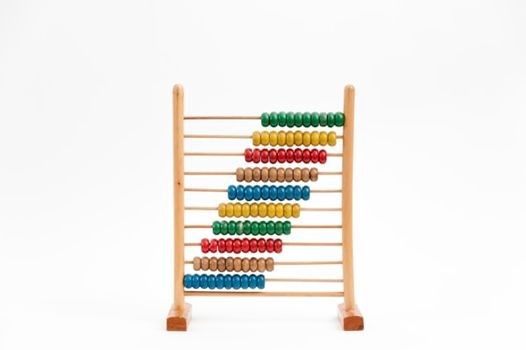

ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-pro. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.

In [27]:
'''prompt = "Describe this image in a short sentence:"
# Image by Crissy Jarvis on Unsplash: https://unsplash.com/photos/cHhbULJbPwM
image_abacus = load_image_from_url(
    "https://unsplash.com/photos/cHhbULJbPwM/download?w=600"
)

contents = [prompt, image_abacus]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)'''

----------------------------------- Contents -----------------------------------

Answer the following questions about this image.
Return the results as a JSON list containing "question" and "answer" key pairs.

QUESTIONS:
- What does the image show?
- How does it work?
- When was it invented?
- What's the name of this object in French, Italian, Spanish, Dutch, and German?
- What are the most prominent colors in the image?



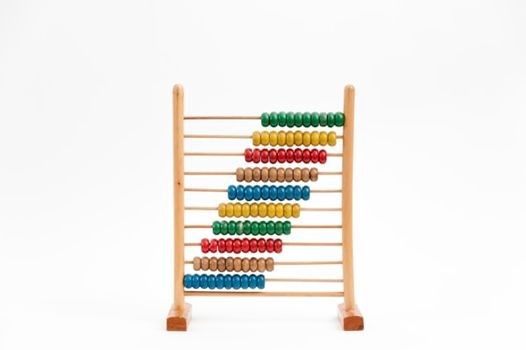

------------------------------ Start of response -------------------------------


```json
[
  {
    "question": "What does the image show?",
    "answer": "The image shows an abacus, a counting tool."
  },
  {
    "question": "How does it work?",
    "answer": "The abacus works by moving beads along rods. Each rod represents a different place value, and the beads are moved to represent numbers and perform calculations."
  },
  {
    "question": "When was it invented?",
    "answer": "The abacus was invented around 2200 BC in Mesopotamia."
  },
  {
    "question": "What's the name of this object in French, Italian, Spanish, Dutch, and German?",
    "answer": "French: boulier\nItalian: abaco\nSpanish: ábaco\nDutch: telraam\nGerman: Abakus"
  },
  {
    "question": "What are the most prominent colors in the image?",
    "answer": "The most prominent colors in the image are the natural wood color, red, green, blue, yellow, and brown."
  }
]
```

------------------------------- End of response --------------------------------



In [28]:
prompt = """
Answer the following questions about this image.
Return the results as a JSON list containing "question" and "answer" key pairs.

QUESTIONS:
- What does the image show?
- How does it work?
- When was it invented?
- What's the name of this object in French, Italian, Spanish, Dutch, and German?
- What are the most prominent colors in the image?
"""

contents = [prompt, image_abacus]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Answer the following questions for each image.
Present the results in a table with a row for each image and a column for each question.

QUESTIONS:
- What can we see in the image?
- Where does it take place? (answer in one word)

Image 1:


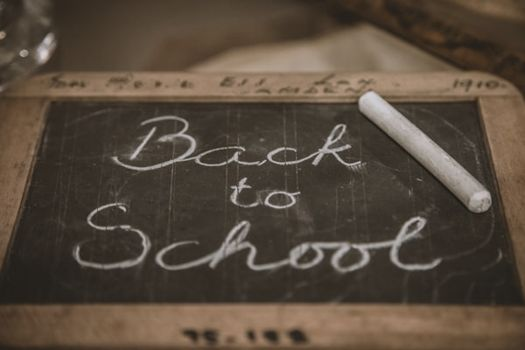

Image 2:


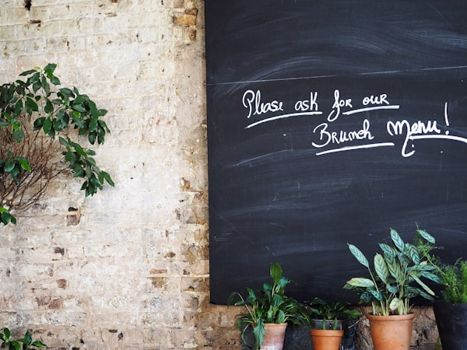

Image 3:


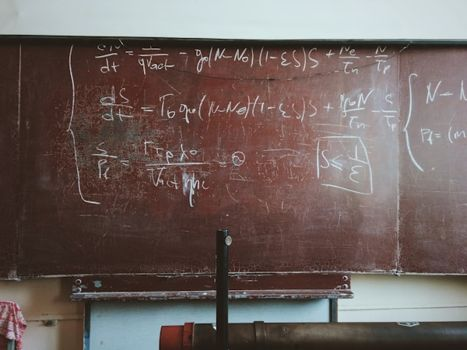

------------------------------ Start of response -------------------------------


## Image Analysis

| Image | What can we see in the image? | Where does it take place? |
|---|---|---|
| 1 | A wooden chalkboard with "Back to School" written on it in chalk. A piece of white chalk rests on the board. | School |
| 2 | A chalkboard leaning against a brick wall with "Please ask for our Brunch menu!" written on it. There are potted plants in front of the board. | Restaurant |
| 3 | A chalkboard in a classroom with complex mathematical formulas and equations written on it. | Classroom |

------------------------------- End of response --------------------------------



In [29]:
prompt = f"""
Answer the following questions for each image.
Present the results in a table with a row for each image and a column for each question.

QUESTIONS:
- What can we see in the image?
- Where does it take place? (answer in one word)
"""
caption_b1 = "Image 1:"
caption_b2 = "Image 2:"
caption_b3 = "Image 3:"
# Photo by Deleece Cook on Unsplash: https://unsplash.com/photos/zzjLGF_6dx4
image_b1 = load_image_from_url("https://unsplash.com/photos/zzjLGF_6dx4/download?w=600")
# Photo by Natasha Kapur on Unsplash: https://unsplash.com/photos/ndAHi2Wxcok
image_b2 = load_image_from_url("https://unsplash.com/photos/ndAHi2Wxcok/download?w=600")
# Photo by Roman Mager on Unsplash: https://unsplash.com/photos/5mZ_M06Fc9g
image_b3 = load_image_from_url("https://unsplash.com/photos/5mZ_M06Fc9g/download?w=600")

contents = [prompt, caption_b1, image_b1, caption_b2, image_b2, caption_b3, image_b3]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

#Playing with Video

In [30]:
gcs_uri = "gs://cloud-samples-data/video/animals.mp4"

prompt = """
Answer the following questions using the video only.
Present the results in a table with a row for each question and its answer, as well as the timestamps where the answer can be found and whether the info source comes from "Image", "Text", and/or "Speech".

QUESTIONS:
- Where was the video likely shot?
- What real animals are first visible as a group?
- What animals are cartoon characters doing a close-up selfie?
- What does the electronic device let real animals do?
- What is the veterinarian full name?
- Where does he work?
- What is Courtney's job position?
- What's her full name?
- Which famous brand is first visible?
- Which famous brand is last visible?
- What happens at timestamp 0:36?
- What happens at timestamp 1:05?
"""

try:
    video = Part.from_uri(
        uri=gcs_uri,
        mime_type="video/mp4",
    )
    print("Video loaded successfully.")
except Exception as e:
    print(f"Error loading video: {e}")
    video = None


if video is None:
    raise ValueError("The video could not be loaded. Please check the URI or your setup.")


contents = [prompt, video]

try:
    response = generate_content(model, contents)
    print("Model response:")
    print_response(response)
except Exception as e:
    print(f"Error during model execution: {e}")


Video loaded successfully.
Model response:
------------------------------ Start of response -------------------------------


| Question | Answer | Timestamp | Info Source |
|---|---|---|---|
| Where was the video likely shot? | Los Angeles Zoo | 0:17 | Speech/Text |
| What real animals are first visible as a group? | Giraffes | 0:19 | Image |
| What animals are cartoon characters doing a close-up selfie? | A fox and a rabbit | 0:13 | Image |
| What does the electronic device let real animals do? | Capture photos of themselves | 0:20 | Speech |
| What is the veterinarian full name? | Evan Antin | 0:57 | Text |
| Where does he work? | Conejo Valley Veterinary Hospital | 0:58 | Text |
| What is Courtney's job position? | Creative Strategist | 1:12 | Text |
| What's her full name? | Courtney Powell | 1:12 | Text |
| Which famous brand is first visible? | Google Photos | 0:05 | Text |
| Which famous brand is last visible? | Disney | 1:33 | Text |
| What happens at timestamp 0:36? | Two elephants are visible | 0:36 | Image |
| What happens at timestamp 1:05? | An otter swims underwater | 1:05 | Image |

------------------------------- End of response --------------------------------

